<a href="https://colab.research.google.com/github/Mamiglia/challenge/blob/master/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import math
from pathlib import Path
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from typing import Callable, Optional 
from challenge.src.common import load_data, prepare_train_data, generate_submission
from challenge.src.eval import evaluate_retrieval, visualize_retrieval

In [45]:
# ==== Config ====
MODEL_PATH = "models/maxmatch_adapter_k4_sinkhorn.pth"
EPOCHS = 20
BATCH_SIZE = 256
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# MaxMatch / Set-based
K_SLOTS = 6                # K moderato (4–6) per efficienza
SLOT_DROPOUT_P = 0.05       # piccolo dropout per diversità iniziale
# Sinkhorn (soft assignment)
SINKHORN_ITERS = 10       # 5–15 è tipico
SINKHORN_TAU = 0.20         # temperatura/entropic reg.; più piccolo = più "dura"
DETACH_ASSIGNMENT = True   # come nel codice MaxMatch: stop-grad sull’assegnamento

# --- MaxMatch hyper ---
SCALE_S    = 0.5    # "s" (scala esponenziale per ISDL/GDL)
DELTA_1    = 0.20   # margine Triplet su S_H (δ1)
DELTA_2    = 0.70   # margine GDL (δ2)
DELTA_3    = 0.70   # margine ISDL (δ3)

LAMBDA_ISDL = 0.25  # peso ISDL (intra-set)
LAMBDA_GDL  = 0.25  # peso GDL  (globale)
LAMBDA_MMD  = 0.01  # opzionale
LAMBDA_DIV  = 0.01  # opzionale


ALPHA_MAX = 0.60


In [46]:
# ============================================================
# 1) Head set-based: t(1024) -> S_T (K x 1536)
# ============================================================
class SetPredictionHead(nn.Module):
    """
    Converte un embedding testuale globale in K slot nello spazio visivo (1536).
    - K query vettori learnable (inizializzati nel target space).
    - Proiezione testo -> spazio visivo + gating per diversificare contributi.
    - Piccolo dropout per evitare collasso precoce.
    """
    def __init__(self, d_text=1024, d_vis=1536, K=4, hidden=2048, slot_dropout_p=0.1):
        super().__init__()
        self.K = K
        self.d_vis = d_vis

        self.text_to_vis = nn.Sequential(
            nn.Linear(d_text, hidden),
            nn.GELU(),
            nn.Linear(hidden, d_vis),
        )

        self.slot_queries = nn.Parameter(torch.randn(K, d_vis) * 0.02)
        self.gate_per_slot = nn.Linear(d_text, K)
        self.delta_per_slot = nn.Linear(d_text, K * d_vis)

        self.ln_slots = nn.LayerNorm(d_vis)
        self.ln_text  = nn.LayerNorm(d_vis)
        self.dropout = nn.Dropout(p=slot_dropout_p)

    def forward(self, t: torch.Tensor):
        B = t.size(0)
        t_vis = self.text_to_vis(t)                 # (B, d_vis)
        t_vis = self.ln_text(t_vis)

        gate  = torch.sigmoid(self.gate_per_slot(t))      # (B, K)
        delta = self.delta_per_slot(t).view(B, self.K, self.d_vis)

        Q = self.slot_queries.unsqueeze(0).expand(B, -1, -1)  # (B, K, d_vis)
        t_vis_exp = t_vis.unsqueeze(1).expand(-1, self.K, -1)
        gate_exp  = gate.unsqueeze(-1)

        # --- residui (pre-fusione globale) ---
        R = Q + gate_exp * t_vis_exp + delta               # (B, K, d_vis)
        R = self.ln_slots(R)
        R = self.dropout(R)
        E_T = F.normalize(R, dim=-1)                       # residui normalizzati (per ISDL)

        # --- fusione globale per scoring ---
        S_T = E_T + F.normalize(t_vis, dim=-1).unsqueeze(1)
        S_T = F.normalize(S_T, dim=-1)
        return S_T, E_T, F.normalize(t_vis, dim=-1)

In [47]:
# ============================================================
# 2) Sinkhorn matching (soft, entropic-regularized doubly-stochastic)
#    sim -> P ~ doubly-stochastic, poi S_H = <P, sim>/K
# ============================================================
def sinkhorn_logspace(log_K: torch.Tensor, iters: int = 10) -> torch.Tensor:
    """
    Log-space Sinkhorn per stabilità numerica.
    log_K: (B, K, K) log-kernel (logits pre-softmax)
    Ritorna log_P: (B, K, K) ~ log matrix bistocastica
    """
    B, K, _ = log_K.shape
    log_u = torch.zeros(B, K, device=log_K.device)
    log_v = torch.zeros(B, K, device=log_K.device)

    for _ in range(iters):
        # normalizza righe
        log_u = -torch.logsumexp(log_K + log_v.unsqueeze(1), dim=2)
        # normalizza colonne
        log_v = -torch.logsumexp(log_K + log_u.unsqueeze(2), dim=1)

    log_P = log_K + log_u.unsqueeze(2) + log_v.unsqueeze(1)
    return log_P

def sinkhorn_assignment(sim: torch.Tensor, tau: float = 0.1, iters: int = 10,
                        detach_input: bool = True) -> torch.Tensor:
    """
    sim: (B, K, K) similarità coseno.
    Costruisce kernel K_ij = exp(sim_ij / tau), applica Sinkhorn per ottenere P ~ bistocastica.
    Se detach_input=True, rimuove il gradiente dalla matrice di sim nel calcolo dell'assegnamento,
    replicando lo schema "stop-grad" usato in MaxMatch per la parte di matching.
    """
    if detach_input:
        sim = sim.detach()
    log_K = sim / max(tau, 1e-6)
    log_P = sinkhorn_logspace(log_K, iters=iters)
    P = torch.exp(log_P)  # (B, K, K), righe/colonne ~ 1
    return P


@torch.no_grad()
def _check_unit_norm(x: torch.Tensor, dim: int = -1, eps: float = 1e-3) -> None:
    # Diagnostica facoltativa: verifica che i vettori siano (circa) normalizzati
    n = x.norm(dim=dim)
    if torch.any((n - 1.0).abs() > eps):
        pass  # non interrompo, ma puoi loggare un warning se ti serve


def s_h_maxmatch_sinkhorn_sets(
    S_T: torch.Tensor,              # (B, K, D)  slots testuali L2-normalizzati
    S_V: torch.Tensor,              # (B, K, D)  slots visivi L2-normalizzati
    *, tau: float, iters: int, detach: bool
) -> torch.Tensor:
    """
    Maximal Pair Assignment Similarity (soft, via Sinkhorn) tra due set (K) per sample.
    Ritorna: (B,) = media del matching pesato dalle similarità.
    """
    assert S_T.dim() == 3 and S_V.dim() == 3, f"shape err: S_T {tuple(S_T.shape)}, S_V {tuple(S_V.shape)}"
    B, K, D = S_T.shape
    assert S_V.shape == (B, K, D), f"shape mismatch: atteso {(B,K,D)}, trovato {tuple(S_V.shape)}"

    # (opzionale) controlli di normalizzazione
    # _check_unit_norm(S_T, dim=-1); _check_unit_norm(S_V, dim=-1)

    sims = torch.matmul(S_T, S_V.transpose(-1, -2))  # (B, K, K), cosine sim
    # Nota: sinkhorn_assignment gestisce già il detach_input
    P = sinkhorn_assignment(sims, tau=tau, iters=iters, detach_input=detach)  # (B, K, K) bistocastica
    return (P * sims).sum(dim=(1, 2)) / K                                     # (B,)


def s_h_maxmatch_sinkhorn(
    S_T: torch.Tensor,              # (B,K,D)
    V: torch.Tensor,                # (B,D)
    *, tau: float, iters: int, detach: bool,
    visual_slotter: Optional[Callable[[torch.Tensor], torch.Tensor]] = None
) -> torch.Tensor:
    """
    Wrapper comodo: se fornisci `visual_slotter(V) -> S_V (B,K,D)` calcola il MaxMatch corretto.
    Se `visual_slotter` è None, solleva errore per evitare la degenerazione (colonne identiche).
    """
    if visual_slotter is None:
        return s_h_singleton_target(S_T, V)
    # Costruisci i K prototipi visivi e normalizzali
    S_V = visual_slotter(V)                         # (B, K, D)
    S_V = F.normalize(S_V, dim=-1)

    return s_h_maxmatch_sinkhorn_sets(
        S_T, S_V, tau=tau, iters=iters, detach=detach
    )



def cosine_matrix(A: torch.Tensor, B: torch.Tensor) -> torch.Tensor:
    # (B, K, D) x (B, D, K) -> (B, K, K)
    return torch.matmul(A, B.transpose(-1, -2))

def s_h_singleton_target(S_T: torch.Tensor, V: torch.Tensor, temp: float = 0.20) -> torch.Tensor:
    # S_T: (B,K,D), V: (B,D)
    Vn   = F.normalize(V, dim=-1)
    sims = torch.einsum('bkd,bd->bk', S_T, Vn)          # (B,K)
    w    = F.softmax(sims / temp, dim=1)                # (B,K) -> enfatizza lo slot migliore
    return (w * sims).sum(dim=1)             # (B,)

def s_h(
    S_T: torch.Tensor,                 # (B,K,D)
    V: torch.Tensor,                   # (B,D) o (B,K,D)
    *, tau: float, iters: int, detach: bool,
    visual_slotter: Optional[Callable[[torch.Tensor], torch.Tensor]] = None
) -> torch.Tensor:
    # Caso 1: già ho S_V (B,K,D) -> set-to-set
    if V.dim() == 3:
        return s_h_maxmatch_sinkhorn_sets(S_T, F.normalize(V, dim=-1),
                                          tau=tau, iters=iters, detach=detach)
    # Caso 2: mi viene fornito un visual_slotter per costruire S_V da V (B,D)
    if visual_slotter is not None:
        S_V = F.normalize(visual_slotter(V), dim=-1)      # (B,K,D)
        return s_h_maxmatch_sinkhorn_sets(S_T, S_V, tau=tau, iters=iters, detach=detach)
    # Caso 3: fallback singleton target (nessun S_V) -> media sui K slot
    return s_h_singleton_target(S_T, V)                   # (B,)




In [ ]:
def triplet_maxmatch_sh(S_T, V, delta1, *, temp=0.20, dup_thresh=0.9995):
    """
    Hardest-negative mining *vero* (solo intra-batch) per il caso singleton-target.
    Vectorized: niente expand/reshape enormi, una sola matmul.
    - Esclude TUTTI i positivi (stessa immagine) nella riga (duplicati inclusi).
    - Prende il massimo residuo (hardest puro).
    """
    B, K, D = S_T.shape
    Vn = F.normalize(V, dim=-1)                    # (B, D)

    # G[i, :, j] = sims dei K slot della riga i contro l'immagine j
    # (B*K, D) @ (D, B) -> (B*K, B) -> (B, K, B)
    G = (S_T.reshape(B*K, D) @ Vn.t()).reshape(B, K, B)

    # softmax sui K slot -> pesi per MPAS singleton; s_all: (B,B)
    W     = F.softmax(G / max(temp, 1e-6), dim=1)
    s_all = (W * G).sum(dim=1)                     # (B, B)

    # positivi (duplicati immagine) da mascherare
    with torch.no_grad():
        vv = Vn @ Vn.t()                           # (B, B) cosine
        pos_mask = vv >= dup_thresh
        pos_mask.fill_diagonal_(True)

    s_pos = s_all.diag()                           # (B,)
    s_neg = s_all.masked_fill(pos_mask, float('-inf')).max(dim=1).values
    s_neg = torch.where(torch.isinf(s_neg), torch.full_like(s_neg, -1.0), s_neg)

    return F.relu(delta1 + s_neg - s_pos).mean()


In [49]:
# ============================================================
# 3) ISDL – Intra-Set Diversity Loss (Alomari 2025)
#     Minimizza similarità intra-slot (promuove diversità)
# ============================================================
def isdl_intra_set_diversity_exp(S_T: torch.Tensor, s: float, delta3: float) -> torch.Tensor:
    B, K, D = S_T.shape
    C = torch.matmul(S_T, S_T.transpose(-1, -2)).clamp(-1, 1)  # (B,K,K)
    mask = ~torch.eye(K, device=S_T.device, dtype=torch.bool).unsqueeze(0).expand(B, K, K)
    C_off = C[mask]  # (B*K*(K-1),)
    loss = torch.exp(s * (C_off - delta3)).mean()
    return loss



In [50]:
# Load data
train_data = load_data("data/train/train.npz")
X, y, label = prepare_train_data(train_data)
DATASET_SIZE = len(X)
# Split train/val
# This is done only to measure generalization capabilities, you don't have to
# use a validation set (though we encourage this)
n_train = int(0.9 * len(X))
TRAIN_SPLIT = torch.zeros(len(X), dtype=torch.bool)
TRAIN_SPLIT[:n_train] = 1
X_train, X_val = X[TRAIN_SPLIT], X[~TRAIN_SPLIT]
y_train, y_val = y[TRAIN_SPLIT], y[~TRAIN_SPLIT]


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
y_train.shape[-1], X_val.shape[-1]

(125000,)
Train data: 125000 captions, 125000 images


(1536, 1024)

In [51]:
# ============================================================
# 4) GDL – Global Discriminative Loss (Alomari 2025)
#     Rafforza separazione vs negativi di batch (ranking)
# ============================================================
def gdl_global_discriminative_true(S_T, t_vis_norm, s: float, delta2: float):
    """
    GDL: penalizza allineamento slot ↔ globale (stessa modalità/spazio),
    spingendo gli slot a non collassare sul globale.
    """
    # sim per-slot col globale: (B,K)
    sims = torch.einsum('bkd,bd->bk', S_T, t_vis_norm).clamp(-1,1)
    return torch.exp(s * (sims - delta2)).mean()




In [52]:
# ============================================================
# 5) Diagnostica: log-varianza intra-slot
# ============================================================
@torch.no_grad()
def slot_log_variance(S_T: torch.Tensor) -> float:
    var_fd = S_T.var(dim=1, unbiased=False)   # (B, D)
    var_mean = var_fd.mean(dim=1).mean().clamp_min(1e-8)
    return float(torch.log(var_mean).item())

In [73]:
def curriculum_params(epoch):
    if epoch <= 3:     # diversità prima, mining stabile
        return dict(
            lambda_isdl=0.12, lambda_gdl=0.00,     # niente GDL early (evita collasso)
            delta1=DELTA_1, delta2=0.74, delta3=DELTA_3,
            scale_s=0.40,
            temp_tri=0.35,                          # MPAS più "morbido"
            mine_mode='topk', k_ratio=0.10
        )
    elif epoch <= 8:   # affila l’assegnamento
        return dict(
            lambda_isdl=0.18, lambda_gdl=0.03,
            delta1=DELTA_1, delta2=0.72, delta3=DELTA_3,
            scale_s=0.45,
            temp_tri=0.23,
            mine_mode='topk', k_ratio=0.15
        )
    else:              # finale: quasi-hardest
        return dict(
            lambda_isdl=0.25, lambda_gdl=0.07,
            delta1=DELTA_1, delta2=0.70, delta3=DELTA_3,
            scale_s=SCALE_S,
            temp_tri=0.15,
            mine_mode='max',  k_ratio=0.20
        )


In [54]:
@torch.no_grad()
def mean_offdiag_cos(E_Tn):
    K = E_Tn.size(1)
    C = torch.matmul(E_Tn, E_Tn.transpose(-1,-2))          # (B,K,K)
    off = C - torch.eye(K, device=E_Tn.device).unsqueeze(0)
    denom = max(K*(K-1), 1)
    return float(off.abs().sum(dim=(1,2)).mean().item() / denom)


In [55]:
def gaussian_kernel(x, y, sigma=1.0):
    x2 = (x*x).sum(dim=1, keepdim=True)
    y2 = (y*y).sum(dim=1, keepdim=True)
    xy = x @ y.t()
    dist = x2 - 2*xy + y2.t()
    return torch.exp(-dist / (2*sigma**2))

def mmd_rbf(x, y, sigma=1.0):
    Kxx = gaussian_kernel(x, x, sigma).mean()
    Kyy = gaussian_kernel(y, y, sigma).mean()
    Kxy = gaussian_kernel(x, y, sigma).mean()
    return Kxx + Kyy - 2*Kxy

def diversity_regularizer_exp(E: torch.Tensor, s: float = 1.0):
    """
    Accetta:
      - E: (B,K,D)  -> viene flattenato a (B*K, D)
      - E: (N,D)    -> usato così com'è
    """
    if E.dim() == 3:
        B, K, D = E.shape
        E = E.reshape(B * K, D)
    elif E.dim() == 2:
        D = E.size(1)
    else:
        raise ValueError(f"diversity_regularizer_exp: atteso 2D/3D, trovato {tuple(E.shape)}")

    C = (E @ E.t()).clamp(-1, 1)  # (N,N)
    mask = ~torch.eye(E.size(0), device=E.device, dtype=torch.bool)
    C_off = C[mask]
    return torch.exp(-2.0 * (1 - C_off)).mean()



In [56]:
def subsample_rows(X: torch.Tensor, max_n: int):
    n = X.size(0)
    if n <= max_n: return X
    idx = torch.randint(0, n, (max_n,), device=X.device)
    return X.index_select(0, idx)

# Subsample per evitare O(n^2) pieno
AGG_MAX = 256      # righe per MMD
RES_MAX = 512      # righe per DIV (BK ~ B*K)

In [57]:
USE_MMD = True
USE_DIV = True

In [58]:
@torch.no_grad()
def assignment_entropy(S_T, V, tau, iters, detach=True):
    # costruisci P come in s_h_maxmatch (singleton target via softmax sui K)
    Vn = F.normalize(V, dim=-1)
    sims = torch.einsum('bkd,bd->bk', S_T, Vn) / max(tau,1e-6)  # (B,K)
    P = F.softmax(sims, dim=1)                                  # (B,K)
    ent = -(P * (P.clamp_min(1e-12).log())).sum(dim=1)          # (B,)
    # normalizza per log K
    return float((ent / math.log(S_T.size(1))).mean().item())


In [ ]:
def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                device: torch.device,
                epochs: int,
                lr: float,
                logvar_warm_epochs: int = 3) -> nn.Module:

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
    best_val = -1e9

    for epoch in range(1, epochs + 1):
        model.train()
        logvar_vals, offdiag_vals = [], []

        for Xb, Yb in tqdm(train_loader, desc=f"[Train] Epoch {epoch}/{epochs}"):
            cur = curriculum_params(epoch)

            Xb = Xb.to(device, non_blocking=True)
            Yb = Yb.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                # --- forward ---
                S_T, E_T, t_vis_n = model(Xb)
                E_Tn = F.normalize(E_T, dim=-1)

                # Ramp semplice: all’inizio più dominio del globale, poi crescono i residui
                alpha = 0.15 if epoch <= 4 else min(ALPHA_MAX, 0.15 + 0.05*(epoch-4))
                S_T = F.normalize(t_vis_n.unsqueeze(1) + alpha * E_Tn, dim=-1)
                                
                # --- diagnostica ---
                if epoch <= logvar_warm_epochs:
                    logvar_vals.append(slot_log_variance(S_T))
                offdiag_vals.append(mean_offdiag_cos(E_Tn))

                # --- loss principali ---
                # 1) Triplet su S_H (hardest-neg su batch) – usa s_h "wrapper" all'interno
                loss_tri = triplet_maxmatch_sh(
                    S_T, Yb, cur["delta1"]
                )

                # 2) ISDL (intra-set, exp con margine)
                loss_isdl = isdl_intra_set_diversity_exp(
                    E_Tn, s=cur["scale_s"], delta3=cur["delta3"]
                )

                # 3) GDL (slot vs globale t_vis nello stesso spazio)
                loss_gdl = gdl_global_discriminative_true(
                    F.normalize(E_T, dim=-1),  # <-- residui
                    t_vis_n,
                    s=cur["scale_s"], delta2=cur["delta2"]
                )

                # 4) Opzionali: MMD (media slot ↔ target) e Diversità residui con subsample
                agg_mean = F.normalize(S_T.mean(dim=1), dim=-1)  # (B,D)
                agg_mean_ss = subsample_rows(agg_mean, AGG_MAX)
                Yb_ss       = subsample_rows(F.normalize(Yb, dim=-1).detach(), AGG_MAX)
                loss_mmd = mmd_rbf(agg_mean_ss, Yb_ss, sigma=1.0)

                E_flat_ss = subsample_rows(E_Tn.reshape(-1, E_Tn.size(-1)), RES_MAX)
                loss_div  = diversity_regularizer_exp(E_flat_ss, s=1.0)

                loss = (loss_tri
                        + cur["lambda_isdl"] * loss_isdl
                        + cur["lambda_gdl"]  * loss_gdl
                        + (LAMBDA_MMD * loss_mmd if USE_MMD else 0.0)
                        + (LAMBDA_DIV * loss_div if USE_DIV else 0.0))

            # --- backward + step (AMP) ---
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt)
            scaler.update()


        # ===== Validation: S_H medio come surrogato, versione rapida =====
        model.eval()
        val_s_h_sum, val_batches = 0.0, 0
        cur_val = curriculum_params(epoch)
        with torch.no_grad():
            for Xb, Yb in DataLoader(val_loader.dataset, batch_size=BATCH_SIZE, shuffle=False):
                Xb = Xb.to(device, non_blocking=True)
                Yb = Yb.to(device, non_blocking=True)
                S_T, E_T, t_vis_n = model(Xb)
                E_Tn = F.normalize(E_T, dim=-1)
                alpha = 0.15 if epoch <= 4 else min(ALPHA_MAX, 0.15 + 0.05*(epoch-4))
                S_T = F.normalize(t_vis_n.unsqueeze(1) + alpha * E_Tn, dim=-1)
                s_h_val = s_h(S_T, Yb, tau=cur_val["tau"], iters=cur_val["iters"], detach=DETACH_ASSIGNMENT)
                val_s_h_sum += float(s_h_val.mean().item())
                val_batches += 1
                ae = assignment_entropy(S_T, Yb, tau=cur_val["tau"], iters=cur_val["iters"], detach=DETACH_ASSIGNMENT)

        val_s_h_avg = val_s_h_sum / max(val_batches, 1)

        logvar_text = ""
        if len(logvar_vals) > 0:
            logvar_epoch = sum(logvar_vals) / len(logvar_vals)
            logvar_text = f" | log-var(S_T): {logvar_epoch:.2f}"

        print(
            f"val s_score={val_s_h_avg:.4f} | loss_tri={float(loss_tri.item()):.4f} "
            f"| isdl={float(loss_isdl.item()):.4f} "
            f"| gdl={float(loss_gdl.item()):.4f} "
            f"| last_loss={float(loss.item()):.4f} |"
            f"offdiag(E_T): {sum(offdiag_vals)/len(offdiag_vals):.4f}{logvar_text}|"
            f"assign_entropy={ae:.3f}"
        )

        if val_s_h_avg > best_val:
            best_val = val_s_h_avg
            Path(MODEL_PATH).parent.mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"  ✓ Saved best (val S_H={val_s_h_avg:.4f})")

    return model


In [74]:
# ============================================================
# 8) Istanziazione e training (coerente con MaxMatch + diagnostiche)
# ============================================================
model = SetPredictionHead(
    d_text=X.shape[1],
    d_vis=y.shape[1],
    K=K_SLOTS,
    hidden=2048,
    slot_dropout_p=SLOT_DROPOUT_P
).to(DEVICE)

print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
print("\n3. Training (MaxMatch + Sinkhorn + ISDL + GDL, con curriculum su τ/iters e monitor ISDL/entropia)...")
@torch.no_grad()
def init_slot_queries_orthogonal(model):
    K, D = model.slot_queries.shape
    M = torch.randn(D, K, device=model.slot_queries.device)
    Q, _ = torch.linalg.qr(M, mode='reduced')      # (D, K) colonne ortonormali
    model.slot_queries.copy_(Q.T * 0.05)           # (K, D)

@torch.no_grad()
def procrustes_init(model, Xp, Yp, max_pairs=20000):
    n = min(Xp.size(0), max_pairs)
    idx = torch.randperm(Xp.size(0), device=Xp.device)[:n]
    Xs = F.normalize(Xp[idx], dim=-1)
    Ys = F.normalize(Yp[idx], dim=-1)
    t_mid = model.text_to_vis[0](Xs)               # Linear(d_text->hidden)
    M = t_mid.T @ Ys                               # (hidden, d_vis)
    U, _, Vh = torch.linalg.svd(M, full_matrices=False)
    W = U @ Vh                                     # (hidden, d_vis)
    last = model.text_to_vis[2]                    # Linear(hidden->d_vis)
    last.weight.copy_(W.T); last.bias.zero_()

# dopo: model = SetPredictionHead(...)
init_slot_queries_orthogonal(model)
procrustes_init(model, X_train.to(DEVICE), y_train.to(DEVICE))

model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    epochs=EPOCHS,
    lr=LR
)



Parameters: 14,714,374

3. Training (MaxMatch + Sinkhorn + ISDL + GDL, con curriculum su τ/iters e monitor ISDL/entropia)...


[Train] Epoch 1/20: 100%|██████████| 440/440 [00:13<00:00, 33.25it/s]


KeyError: 'tau'

In [66]:
# Carica best e imposta eval
state = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()


SetPredictionHead(
  (text_to_vis): Sequential(
    (0): Linear(in_features=1024, out_features=2048, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=2048, out_features=1536, bias=True)
  )
  (gate_per_slot): Linear(in_features=1024, out_features=6, bias=True)
  (delta_per_slot): Linear(in_features=1024, out_features=9216, bias=True)
  (ln_slots): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
  (ln_text): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.05, inplace=False)
)

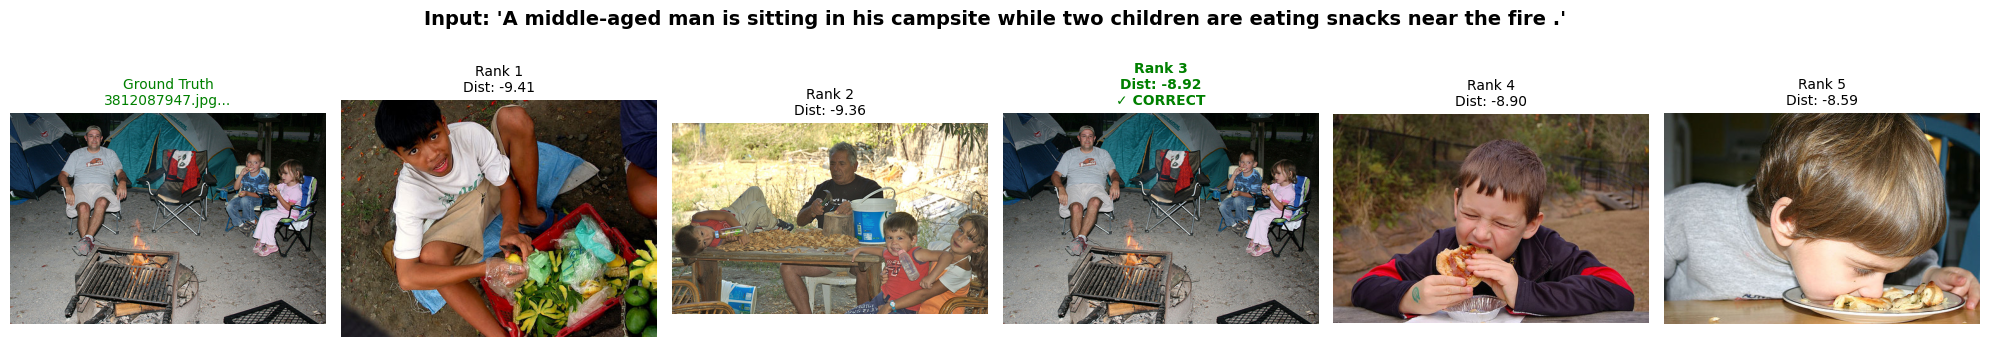

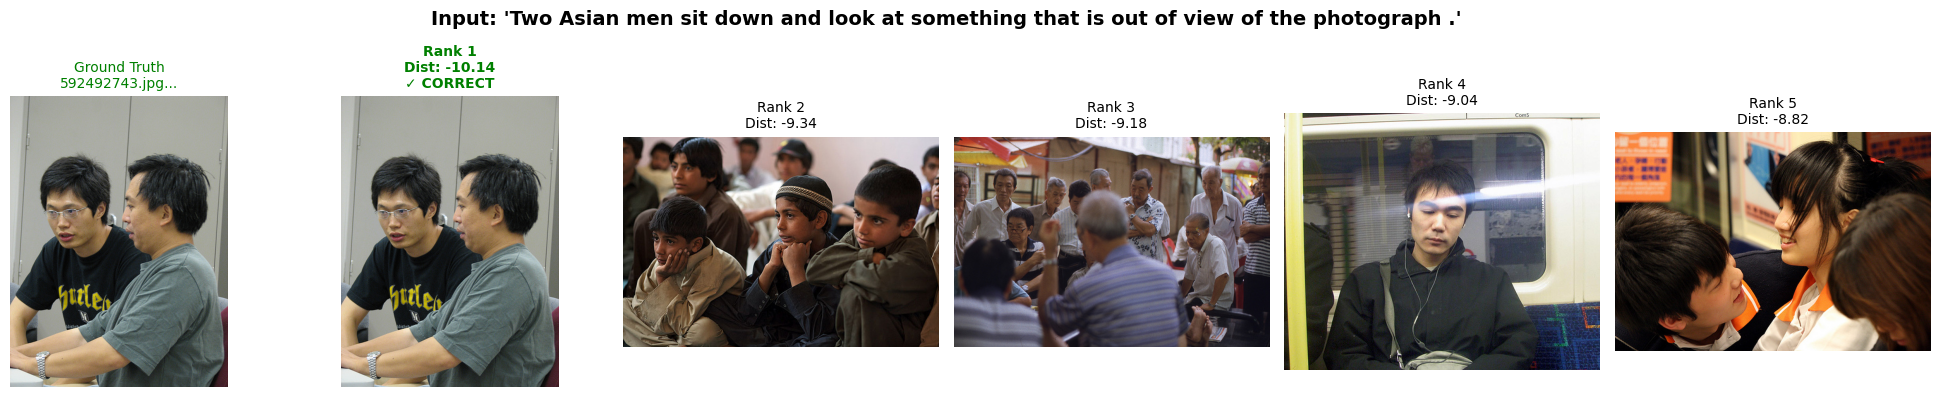

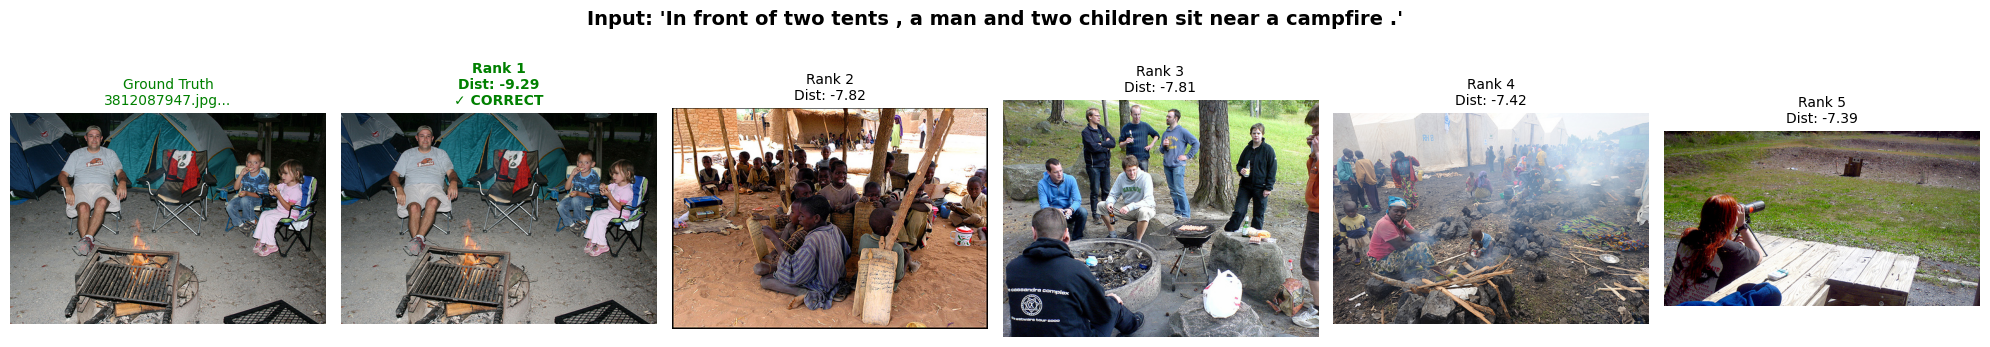


=== Validation Retrieval Metrics (MaxMatch+ISDL+GDL, agg='mean') ===
mrr            : 0.1580
ndcg           : 0.3253
recall_at_1    : 0.0478
recall_at_3    : 0.1378
recall_at_5    : 0.2213
recall_at_10   : 0.4081
recall_at_50   : 0.9697
l2_dist        : 1.1750


In [69]:
# ============================================================
# 9) Aggregazione slot -> 1 embedding (submission compatibile)
# ============================================================
@torch.no_grad()
def aggregate_slots(S_T, mode="soft_winner", temp=0.20, V_ref=None):
    if mode == "mean" or V_ref is None:
        return F.normalize(S_T.mean(dim=1), dim=-1)
    # soft-winner guidato dalla similarità con V_ref (se disponibile in val)
    Vn   = F.normalize(V_ref, dim=-1)
    sims = torch.einsum('bkd,bd->bk', S_T, Vn)       # (B,K)
    w    = F.softmax(sims / temp, dim=1).unsqueeze(-1)
    out  = (w * S_T).sum(dim=1)
    return F.normalize(out, dim=-1)


# Visualizza qualche retrieval
import numpy as np
val_caption_text = train_data['captions/text'][~TRAIN_SPLIT]
val_text_embd = X_val
img_VAL_SPLIT = label[~TRAIN_SPLIT].sum(dim=0) > 0
val_img_file = train_data['images/names'][img_VAL_SPLIT]
val_img_embd = torch.from_numpy(train_data['images/embeddings'][img_VAL_SPLIT])
val_label = np.nonzero(train_data['captions/label'][~TRAIN_SPLIT][:, img_VAL_SPLIT])[1]

for i in range(3):
    idx = np.random.randint(0, min(100, len(val_text_embd)))
    caption_embd = val_text_embd[idx:idx+1].to(DEVICE)
    caption_text = val_caption_text[idx]
    gt_index = val_label[idx]
    with torch.no_grad():
        S_T, _, _ = model(caption_embd)
        pred_embd = aggregate_slots(S_T, mode="mean").cpu().squeeze(0)
        visualize_retrieval(pred_embd, gt_index, val_img_file, caption_text, val_img_embd, k=5)

# Retrieval eval (compatibile con funzione originale)
with torch.no_grad():
    preds_val = []
    for Xb in DataLoader(val_dataset.tensors[0], batch_size=BATCH_SIZE):
        Xb = Xb.to(DEVICE)
        S_Tb, _, _ = model(Xb)
        Eb = aggregate_slots(S_Tb, mode="mean")
        preds_val.append(Eb.cpu())
    z_pred_val = torch.cat(preds_val, dim=0)

n_caps = z_pred_val.shape[0]
n_imgs = val_img_embd.shape[0]
if n_imgs < n_caps:
    n_repeat = int(np.ceil(n_caps / n_imgs))
    image_embd_equal = val_img_embd.repeat((n_repeat, 1))[:n_caps]
elif n_imgs > n_caps:
    image_embd_equal = val_img_embd[:n_caps]
else:
    image_embd_equal = val_img_embd

gt_equal = val_label[:n_caps]

image_embd_equal = F.normalize(image_embd_equal, dim=-1)
z_pred_val       = F.normalize(z_pred_val, dim=-1)

results = evaluate_retrieval(
    translated_embd=z_pred_val,
    image_embd=image_embd_equal,
    gt_indices=gt_equal,
    max_indices=min(99, image_embd_equal.shape[0]),
    batch_size=100
)
print("\n=== Validation Retrieval Metrics (MaxMatch+ISDL+GDL, agg='mean') ===")
for name, value in results.items():
    print(f"{name:15s}: {value:.4f}")


In [68]:
with torch.no_grad():
    # 1) Predizioni (CPU, L2-normalizzate)
    preds_val_mean, preds_val_win = [], []
    for Xb, Yb in DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False):
        Xb = Xb.to(DEVICE); Yb = Yb.to(DEVICE)
        S_Tb, _, _ = model(Xb)                              # (B,K,D)
        Eb_mean = aggregate_slots(S_Tb, mode="mean")     # (B,D)
        Eb_win  = aggregate_slots(S_Tb, V_ref=Yb, mode="winner")
        preds_val_mean.append(Eb_mean.cpu())
        preds_val_win.append(Eb_win.cpu())

    Z_mean = F.normalize(torch.cat(preds_val_mean, dim=0), dim=-1).cpu()  # (Nq,D)
    Z_win  = F.normalize(torch.cat(preds_val_win,  dim=0), dim=-1).cpu()  # (Nq,D)

# 2) Equalizza a Nq e **RIORDINA** le immagini secondo gt (allineamento 1-a-1 nel batch)
nq        = Z_mean.size(0)
gt_equal  = np.asarray(val_label[:nq], dtype=np.int64)   # <-- usa i GT reali relativi alla galleria filtrata
IMG_ALL_n = F.normalize(val_img_embd, dim=-1).cpu()
IMG_EQ    = IMG_ALL_n[torch.from_numpy(gt_equal)]        # (Nq, D)

# dopo il riordino, i nuovi GT sono semplicemente 0..Nq-1
gt_eq_reindexed = np.arange(nq, dtype=np.int64)


# 3) Scegli un batch “sicuro” che divide Nq e imposta k ≤ batch
def best_divisor(n, cap=100):
    for d in [cap, 64, 50, 40, 32, 25, 20, 16, 10, 8, 5, 4, 2, 1]:
        if d <= n and n % d == 0:
            return d
    # fallback
    for d in range(min(cap, n), 0, -1):
        if n % d == 0:
            return d
    return 1

safe_batch = best_divisor(nq, 100)
safe_k     = min(50, safe_batch)   # <= SEMPRE ≤ batch del prof

# 4) Valutazione (mean e winner) – tutto CPU, k e batch sicuri, immagini allineate
res_mean = evaluate_retrieval(
    translated_embd=Z_mean, 
    image_embd=IMG_EQ, 
    gt_indices=gt_eq_reindexed,
    max_indices=safe_k,
    batch_size=safe_batch
)
res_win = evaluate_retrieval(
    translated_embd=Z_win, 
    image_embd=IMG_EQ, 
    gt_indices=gt_eq_reindexed,
    max_indices=safe_k,
    batch_size=safe_batch
)

print("\n=== agg='mean' ===")
for k,v in res_mean.items(): print(f"{k:15s}: {v:.4f}")
print("\n=== agg='winner' ===")
for k,v in res_win.items():  print(f"{k:15s}: {v:.4f}")



=== agg='mean' ===
mrr            : 0.4238
ndcg           : 0.5617
recall_at_1    : 0.1799
recall_at_3    : 0.5438
recall_at_5    : 0.9098
recall_at_10   : 0.9683
recall_at_50   : 0.9988
l2_dist        : 1.1750

=== agg='winner' ===
mrr            : 0.4258
ndcg           : 0.5633
recall_at_1    : 0.1824
recall_at_3    : 0.5475
recall_at_5    : 0.9116
recall_at_10   : 0.9689
recall_at_50   : 0.9990
l2_dist        : 1.1734


In [ ]:
# ============================================================
# 10) Submission (robusta)
# ============================================================
test_data   = load_data("data/test/test.clean.npz")
test_ids    = test_data['captions/ids']
test_embds  = torch.from_numpy(test_data['captions/embeddings']).float()  # (N,D_t)

@torch.no_grad()
def predict_one(Xb, tau_infer=0.15):
    S_Tb, _, _ = model(Xb)
    mean = F.normalize(S_Tb.mean(dim=1), dim=-1)
    sims = torch.einsum('bkd,bd->bk', S_Tb, mean)
    w = F.softmax(sims / tau_infer, dim=1).unsqueeze(-1)
    win = F.normalize((w * S_Tb).sum(dim=1), dim=-1)
    return F.normalize(mean + win, dim=-1)

pred_chunks = []
with torch.inference_mode():
    model.eval()
    for Xb in DataLoader(test_embds, batch_size=BATCH_SIZE, shuffle=False):
        Xb = Xb.to(DEVICE)
        Eb = predict_one(Xb, tau_infer=0.15)
        pred_chunks.append(Eb.cpu().to(torch.float32))


# sanity checks
assert pred_embds_test.ndim == 2, f"Got shape {tuple(pred_embds_test.shape)}"
assert len(test_ids) == pred_embds_test.size(0), \
    f"ids({len(test_ids)}) != preds({pred_embds_test.size(0)})"

# opzionale: salva per analisi locale
np.save("pred_test_embeddings.npy", pred_embds_test.numpy())

# genera CSV (funzione del prof accetta anche torch.Tensor)
submission = generate_submission(test_ids, pred_embds_test, 'submission.csv')
print(f"Model saved to: {MODEL_PATH}")
print("Submission saved to: submission.csv")


Generating submission file...
✓ Saved submission to submission.csv
Model saved to: models/maxmatch_adapter_k4_sinkhorn.pth
Submission saved to: submission.csv
